<a href="https://colab.research.google.com/github/vinitakawale/SyntheticAnomalyDetection/blob/main/MLAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.6 MB/s eta 0:00:00


In [22]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import bz2
import math
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtw_viz
import datetime
from typing import Dict
from Synthetic import SyntheticTS
from autoencoders import Autoencoder
from plot import plot_anomaly

In [3]:
start_time = '2021-05-01 00:00:00'
end_time = '2021-05-06 06:00:00'
process_time_mins = 15

ts = SyntheticTS(start_time,end_time,process_time_mins)

In [4]:
ts

Customized synthetic time series class

In [5]:
print(ts)

Parameters
Start time: 2021-05-01 00:00:00
End time: 2021-05-06 06:00:00 
Process time (minutes): 15
        


In [6]:
ts.plot_normal()

Nothing initialized


In [7]:
ts.plot_anomaly()

Nothing anomalized


In [8]:
df=ts.normal_process(loc=100,scale=5)
df.head()

,time,normal_data
0,2021-05-01 00:00:00,93.379126
1,2021-05-01 00:15:00,97.393568
2,2021-05-01 00:30:00,95.799186
3,2021-05-01 00:45:00,96.264697
4,2021-05-01 01:00:00,105.847734


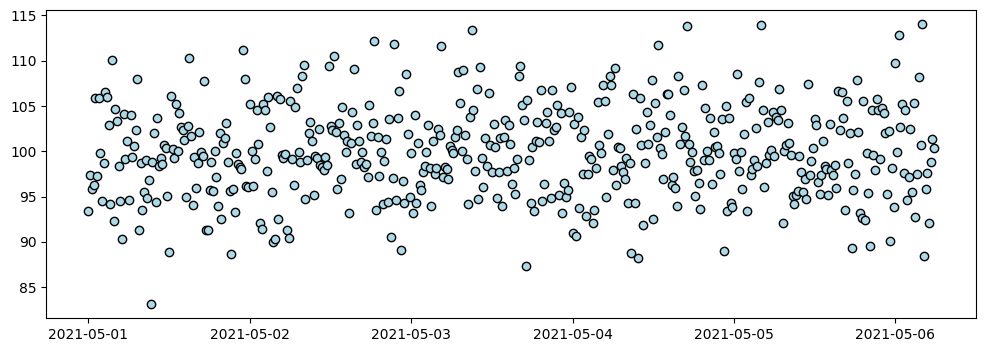

In [9]:
ts.plot_normal()

In [10]:
df2 = ts.anomalize()
df2.head()

,time,anomaly_data
0,2021-05-01 00:00:00,93.379126
1,2021-05-01 00:15:00,97.393568
2,2021-05-01 00:30:00,95.799186
3,2021-05-01 00:45:00,96.264697
4,2021-05-01 01:00:00,105.847734


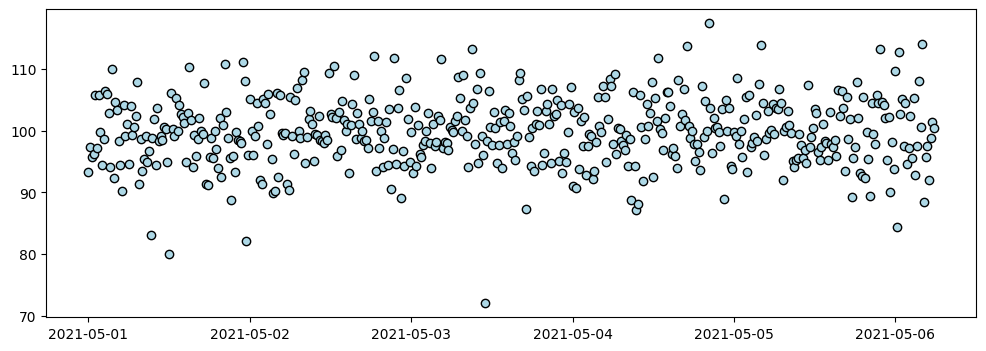

In [11]:
ts.plot_anomaly()

In [12]:
df_normal = pd.DataFrame({"timestamp": df["time"], "value":df["normal_data"]})
df_anomaly = pd.DataFrame({"timestamp": df2["time"], "value":df2["anomaly_data"]})


# Autoencoders

In [17]:
anomaly_scores_normal = Autoencoder(df_normal)
anomaly_scores_anomaly = Autoencoder(df_anomaly)


# # Exclude datetime column again
# data_tensor = tf.convert_to_tensor(data_converted.drop(
#     'timestamp', axis=1).values, dtype=tf.float32)


# # Define the autoencoder model
# input_dim = data_converted.shape[1] - 1
# encoding_dim = 10

# input_layer = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation='relu')(input_layer)
# decoder = Dense(input_dim, activation='relu')(encoder)
# autoencoder = Model(inputs=input_layer, outputs=decoder)

# # Compile and fit the model
# autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(data_tensor, data_tensor, epochs=50,
#                 batch_size=32, shuffle=True)

# # Calculate the reconstruction error for each data point
# reconstructions = autoencoder.predict(data_tensor)
# mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
#                      axis=1)
# anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
# anomaly_scores.index = data_converted.index

Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 5665.4526
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 4878.7085
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 4185.1245
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 3579.0457
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 3051.3650
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 2591.7717
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 2191.5667
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 1842.1005
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 1560.4781
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 1364.4236
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 1205.4128
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 1058.9739
Epoch 13/50
1

In [19]:
threshold_normal = anomaly_scores_normal.quantile(0.99)
anomalous_normal = anomaly_scores_normal > threshold_normal
binary_labels = anomalous_normal.astype(int)
precision, recall,f1_score, _ = precision_recall_fscore_support(
        anomalous_normal, anomalous_normal, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [20]:
threshold_anomaly = anomaly_scores_anomaly.quantile(0.99)
anomalous_anomaly = anomaly_scores_anomaly > threshold_anomaly
binary_labels = anomalous_normal.astype(int)
precision, recall,f1_score, _ = precision_recall_fscore_support(
        anomalous_normal, anomalous_normal, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [21]:
test_normal = df_normal['value'].values
predictions_normal = anomaly_scores_normal.values
print("Test: ", test_normal)
print("Predictions: ", predictions_normal)

Test:  [ 93.37912584  97.39356763  95.79918623  96.26469665 105.84773399
  97.24342465 105.87822678  99.84298932  94.5093823   98.67713062
 106.51260254 105.96051917 102.9153183   94.14831499 110.04128627
  92.29335913 104.71217271 103.3559765   98.36179956  94.45953304
  90.29862585 104.16107781  99.10218576 101.11164532  94.59459807
 103.95398712  99.35567873 100.54476462 102.38631394 107.92434355
  91.31097163  98.74139444  93.4883976   95.47942214  99.08690249
  94.87060788  96.79115612  83.10198972  98.80807082 101.98121546
  94.42674055 103.64938861  98.33685391  99.2311832   98.57979273
 100.68032625 100.32625955  95.00880516  88.84558697 106.1392649
 100.28395326  99.23764509 105.26795817 100.02206089 104.24241049
 102.71033609 102.29690291 101.20561465  94.89639908 102.82037293
 110.28350821 101.72195884  94.07798666  99.34934344  95.91937858
  98.74761339 102.10771814  99.93049129  99.47160401 107.80988413
  91.34218952  91.26275872  95.73114438  98.76250411  95.62819744
  99

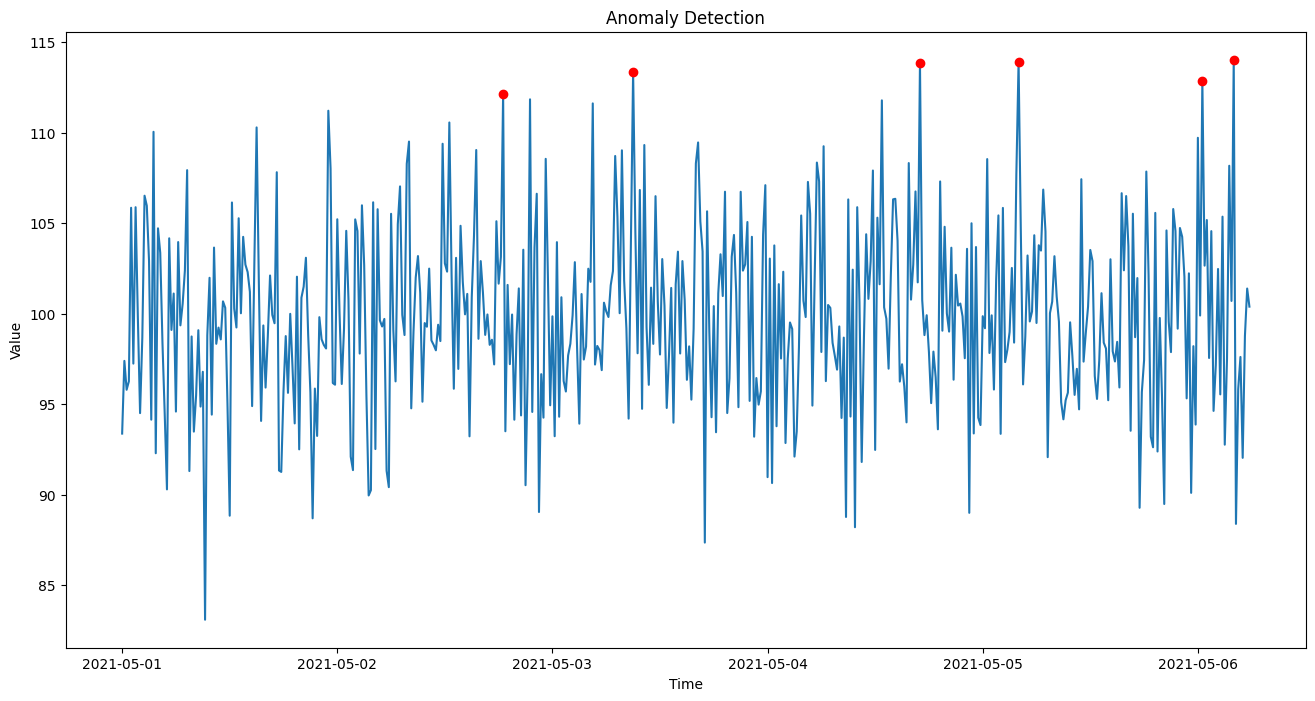

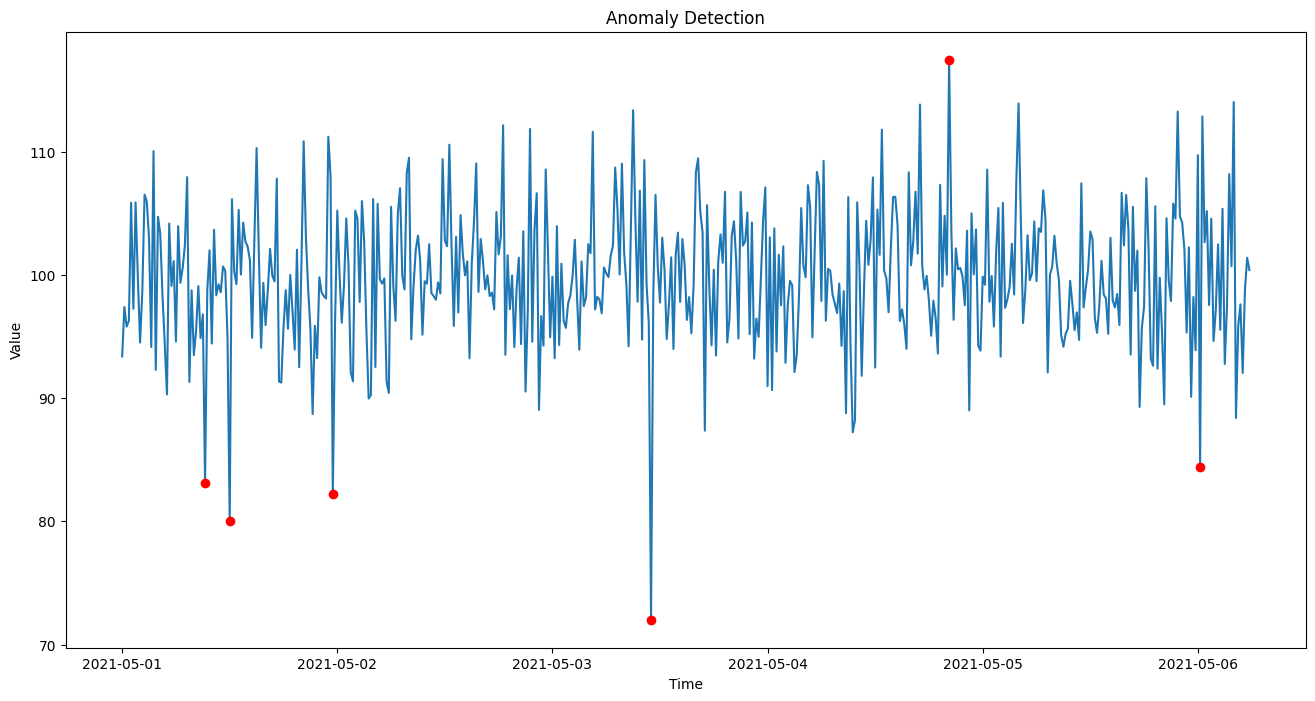

In [24]:
plot_anomaly(df_normal, anomalous_normal)
plot_anomaly(df_anomaly, anomalous_anomaly)

# # Plot the data with anomalies marked in red
# plt.figure(figsize=(16, 8))
# plt.plot(data_converted['timestamp'],
#          data_converted['value'])
# plt.plot(data_converted['timestamp'][anomalous],
#          data_converted['value'][anomalous], 'ro')
# plt.title('Anomaly Detection')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.show()
